In [206]:
!pip install lightgbm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint
import scipy.stats as stats

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
import lightgbm 
from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [147]:
train_data=pd.read_csv('train.csv')
train_data=train_data.drop(['Surname'],axis=1)
test_data=pd.read_csv('test.csv')
test_data=test_data.drop(['Surname'],axis=1)
test_data

,id,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00
...,...,...,...,...,...,...,...,...,...,...,...,...
110018,275052,15662091,570,Spain,Male,29.0,7,116099.82,1,1.0,1.0,148087.62
110019,275053,15774133,575,France,Female,36.0,4,178032.53,1,1.0,1.0,42181.68
110020,275054,15728456,712,France,Male,31.0,2,0.00,2,1.0,0.0,16287.38
110021,275055,15687541,709,France,Female,32.0,3,0.00,1,1.0,1.0,158816.58


In [148]:
pd.DataFrame(train_data.describe())

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [149]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  object 
 4   Gender           165034 non-null  object 
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  float64
 10  IsActiveMember   165034 non-null  float64
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(2)
memory usage: 16.4+ MB


In [150]:
train_data.shape

(165034, 13)

In [151]:
num_cols_train=train_data.select_dtypes(include=['int64','float64'])
cat_cols_train=train_data.select_dtypes(include=['object'])
num_cols_test=test_data.select_dtypes(include=['int64','float64'])
cat_cols_test=test_data.select_dtypes(include=['object'])

In [152]:
variations = train_data[train_data['Exited']==1]['NumOfProducts']
variations.value_counts()

NumOfProducts
1    26858
2     5093
3     2554
4      416
Name: count, dtype: int64

In [153]:
train_data

,id,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0
165030,165030,15665521,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0
165031,165031,15664752,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0
165032,165032,15689614,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0


# Encoding features

In [154]:
cat_cols_train

,Geography,Gender
0,France,Male
1,France,Male
2,France,Male
3,France,Male
4,Spain,Male
...,...,...
165029,Spain,Female
165030,France,Male
165031,France,Male
165032,Spain,Female


In [155]:
Geo=pd.get_dummies(cat_cols_train,columns=['Geography','Gender'],dtype=int)
Geo=Geo.drop(['Geography_France','Gender_Female'],axis=1)
Geo

,Geography_Germany,Geography_Spain,Gender_Male
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,1,1
...,...,...,...
165029,0,1,0
165030,0,0,1
165031,0,0,1
165032,0,1,0


In [156]:
new_train_data=train_data
new_train_data=new_train_data.drop(['Geography','Gender'],axis=1)
new_train_data=pd.concat([new_train_data,Geo],axis=1)
new_train_data

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,0,15674932,668,33.0,3,0.00,2,1.0,0.0,181449.97,0,0,0,1
1,1,15749177,627,33.0,1,0.00,2,1.0,1.0,49503.50,0,0,0,1
2,2,15694510,678,40.0,10,0.00,2,1.0,0.0,184866.69,0,0,0,1
3,3,15741417,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0,0,1
4,4,15766172,716,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,667,33.0,2,0.00,1,1.0,1.0,131834.75,0,0,1,0
165030,165030,15665521,792,35.0,3,0.00,1,0.0,0.0,131834.45,0,0,0,1
165031,165031,15664752,565,31.0,5,0.00,1,1.0,1.0,127429.56,0,0,0,1
165032,165032,15689614,554,30.0,7,161533.00,1,0.0,1.0,71173.03,0,0,1,0


In [157]:
Geo=pd.get_dummies(cat_cols_test,columns=['Geography','Gender'],dtype=int)
Geo=Geo.drop(['Geography_France','Gender_Female'],axis=1)
Geo

,Geography_Germany,Geography_Spain,Gender_Male
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,1
4,1,0,1
...,...,...,...
110018,0,1,1
110019,0,0,0
110020,0,0,1
110021,0,0,0


In [158]:
new_test_data=test_data
new_test_data=new_test_data.drop(['Geography','Gender'],axis=1)
new_test_data=pd.concat([new_test_data,Geo],axis=1)
new_test_data

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,165034,15773898,586,23.0,2,0.00,2,0.0,1.0,160976.75,0,0,0
1,165035,15782418,683,46.0,2,0.00,1,1.0,0.0,72549.27,0,0,0
2,165036,15807120,656,34.0,7,0.00,2,1.0,0.0,138882.09,0,0,0
3,165037,15808905,681,36.0,8,0.00,1,1.0,0.0,113931.57,0,0,1
4,165038,15607314,752,38.0,10,121263.62,1,1.0,0.0,139431.00,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110018,275052,15662091,570,29.0,7,116099.82,1,1.0,1.0,148087.62,0,1,1
110019,275053,15774133,575,36.0,4,178032.53,1,1.0,1.0,42181.68,0,0,0
110020,275054,15728456,712,31.0,2,0.00,2,1.0,0.0,16287.38,0,0,1
110021,275055,15687541,709,32.0,3,0.00,1,1.0,1.0,158816.58,0,0,0


In [159]:
y_train=new_train_data.Exited
new_train_data=new_train_data.drop('Exited',axis=1)
new_train_data.shape

(165034, 13)

In [160]:
new_test_data.shape

(110023, 13)

In [161]:
X_train=new_train_data
X_test=new_test_data
X_train

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,0,15674932,668,33.0,3,0.00,2,1.0,0.0,181449.97,0,0,1
1,1,15749177,627,33.0,1,0.00,2,1.0,1.0,49503.50,0,0,1
2,2,15694510,678,40.0,10,0.00,2,1.0,0.0,184866.69,0,0,1
3,3,15741417,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0,1
4,4,15766172,716,33.0,5,0.00,2,1.0,1.0,15068.83,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,667,33.0,2,0.00,1,1.0,1.0,131834.75,0,1,0
165030,165030,15665521,792,35.0,3,0.00,1,0.0,0.0,131834.45,0,0,1
165031,165031,15664752,565,31.0,5,0.00,1,1.0,1.0,127429.56,0,0,1
165032,165032,15689614,554,30.0,7,161533.00,1,0.0,1.0,71173.03,0,1,0


# Feature Engineering and Selection

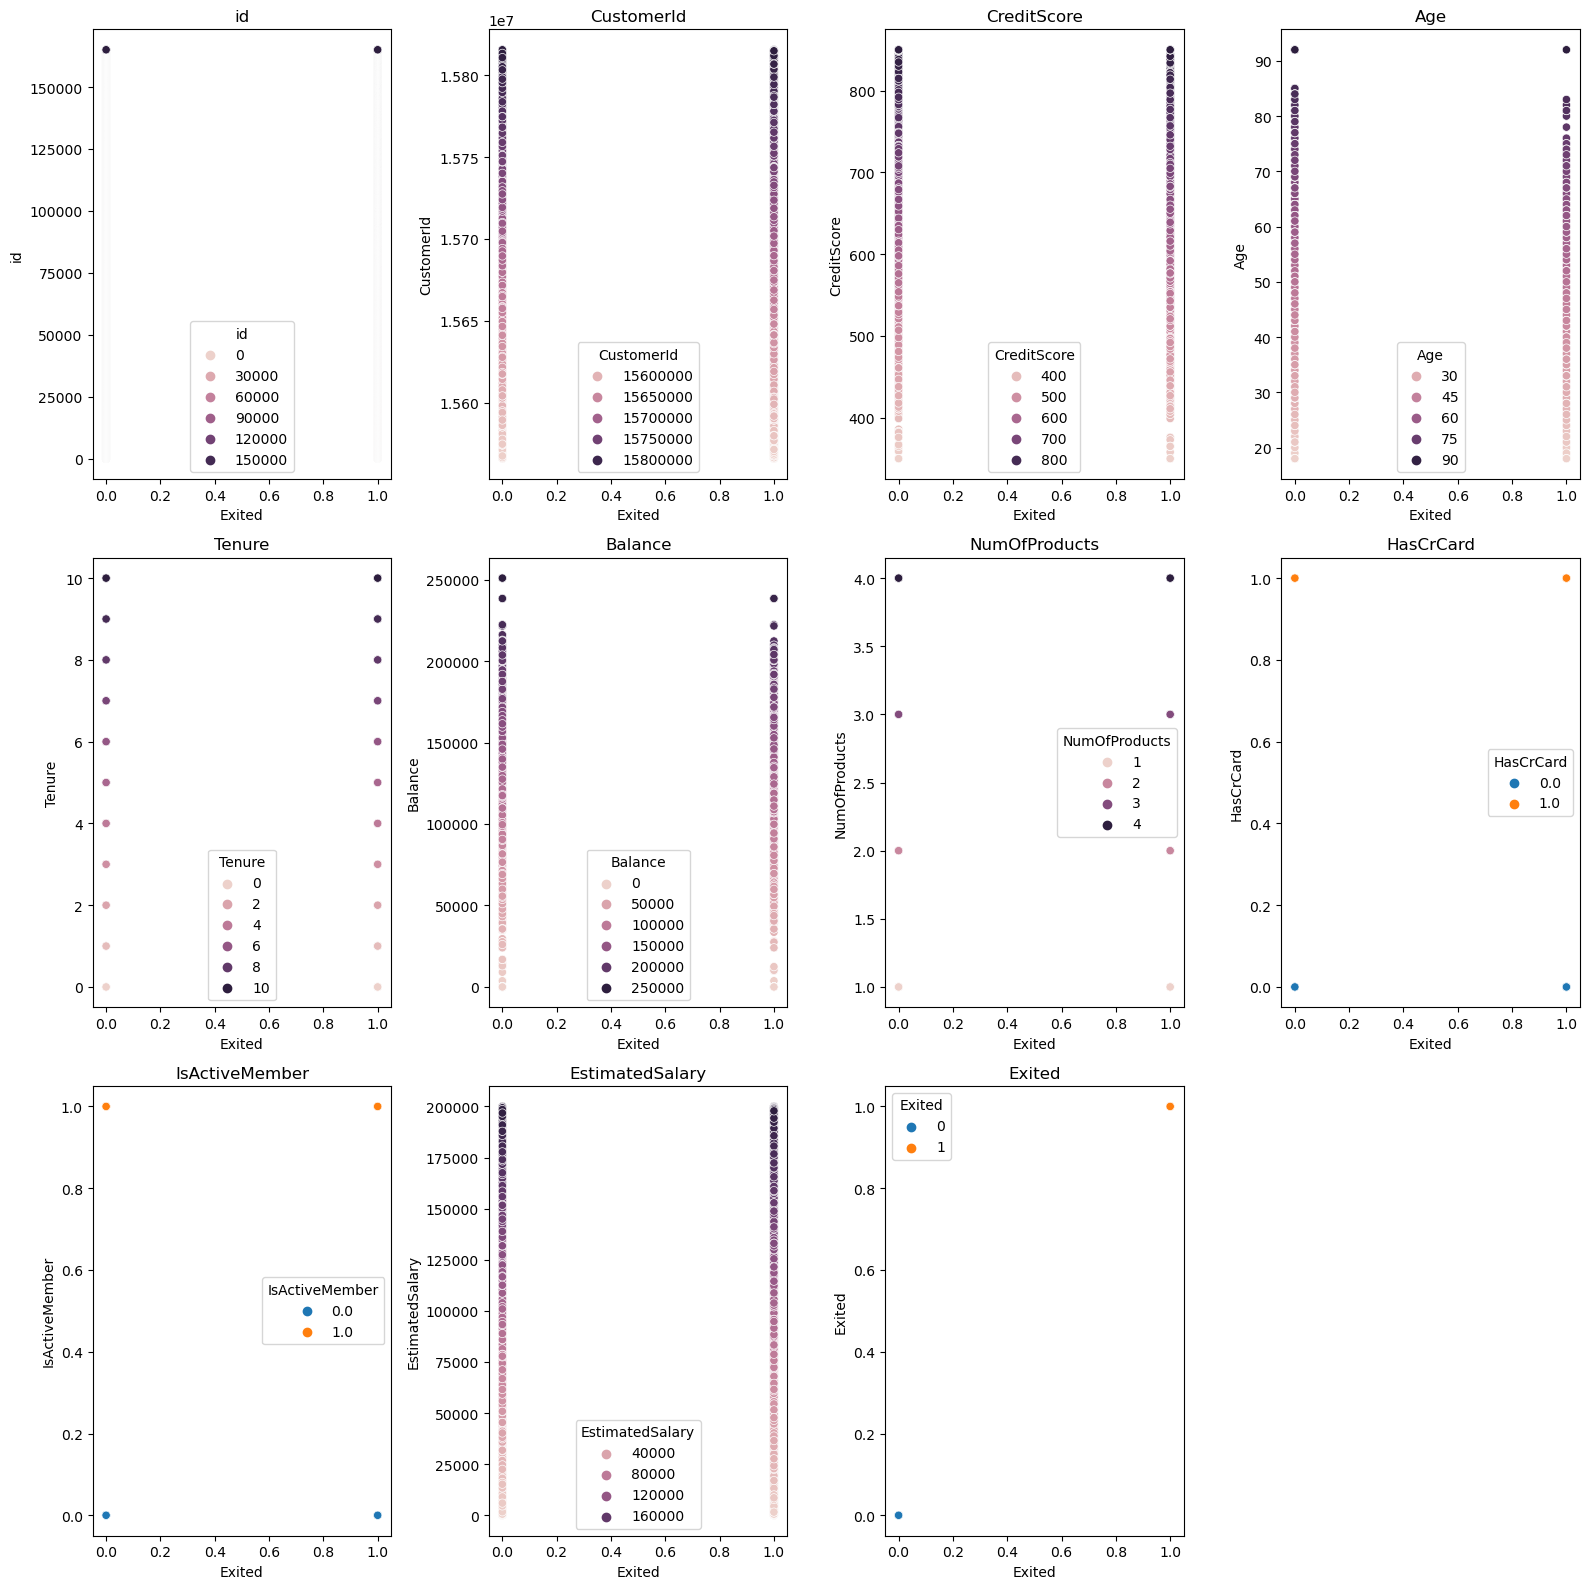

In [162]:
fig=plt.figure(figsize=(16,16))
i=1
for cols in num_cols_train[:-2].columns:
    plt.subplot(3,4,i)
    sns.scatterplot(num_cols_train,x=num_cols_train.Exited,y=num_cols_train[cols],hue=cols)
    plt.title(cols)
    i+=1
plt.tight_layout()
plt.show()

C:\Users\siddh\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


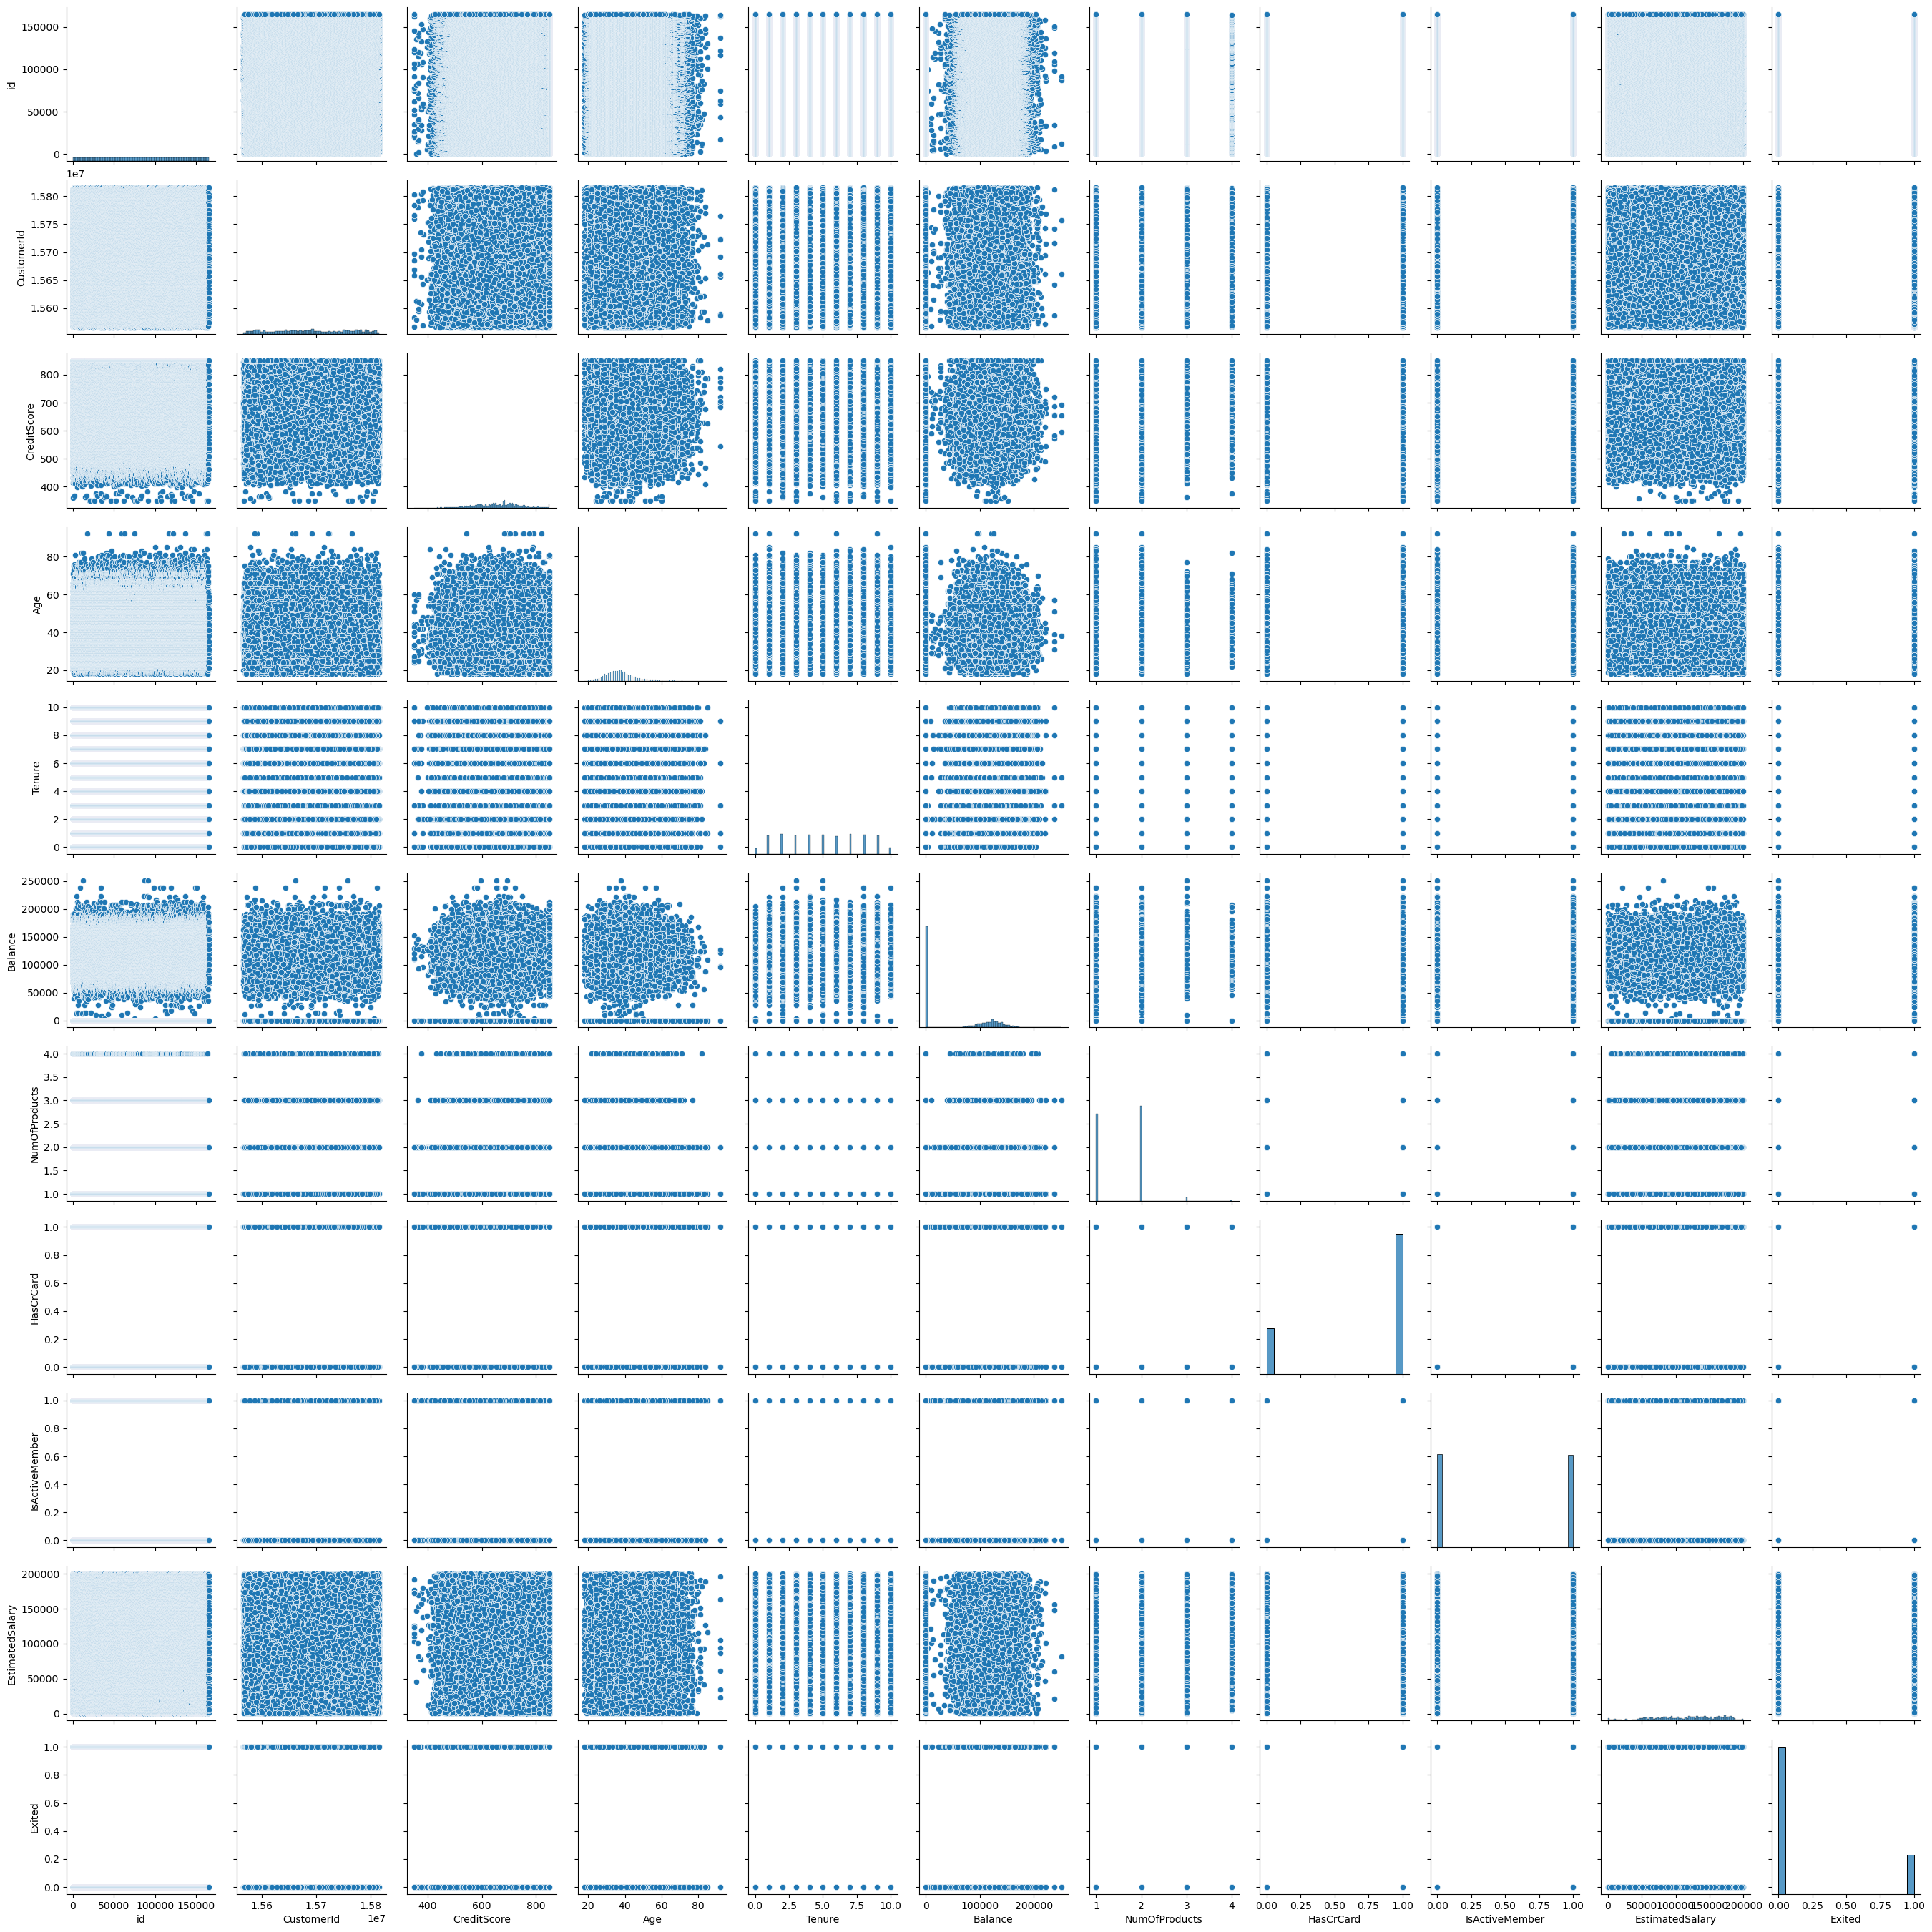

In [208]:
sns.pairplot(num_cols_train)

In [164]:
mfc=mutual_info_classif(X_train,y_train)

mfc_cols=pd.DataFrame()
mfc_cols['Feature Name']=X_train.columns
mfc_cols['Score']=mfc
selected_features = mfc_cols[mfc_cols['Score'] < 0.01]['Feature Name'].tolist()
selected_features

['id',
 'CustomerId',
 'CreditScore',
 'Tenure',
 'EstimatedSalary',
 'Geography_Spain']

In [165]:
mfc_cols

,Feature Name,Score
0,id,0.000023
1,CustomerId,0.003250
2,CreditScore,0.001990
3,Age,0.084254
4,Tenure,0.003891
5,Balance,0.016657
6,NumOfProducts,0.099273
7,HasCrCard,0.022578
8,IsActiveMember,0.043064
9,EstimatedSalary,0.006780


In [166]:
new_tenure=(X_train.Age*X_train.Tenure)/2
new_X_train=X_train
new_X_train['new_Tenure']=new_tenure
new_X_train

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,new_Tenure
0,0,15674932,668,33.0,3,0.00,2,1.0,0.0,181449.97,0,0,1,49.5
1,1,15749177,627,33.0,1,0.00,2,1.0,1.0,49503.50,0,0,1,16.5
2,2,15694510,678,40.0,10,0.00,2,1.0,0.0,184866.69,0,0,1,200.0
3,3,15741417,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0,1,34.0
4,4,15766172,716,33.0,5,0.00,2,1.0,1.0,15068.83,0,1,1,82.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,667,33.0,2,0.00,1,1.0,1.0,131834.75,0,1,0,33.0
165030,165030,15665521,792,35.0,3,0.00,1,0.0,0.0,131834.45,0,0,1,52.5
165031,165031,15664752,565,31.0,5,0.00,1,1.0,1.0,127429.56,0,0,1,77.5
165032,165032,15689614,554,30.0,7,161533.00,1,0.0,1.0,71173.03,0,1,0,105.0


In [167]:
new_tenure=(X_test.Age*X_test.Tenure)/2
new_X_test=X_test
new_X_test['new_Tenure']=new_tenure
new_X_test

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,new_Tenure
0,165034,15773898,586,23.0,2,0.00,2,0.0,1.0,160976.75,0,0,0,23.0
1,165035,15782418,683,46.0,2,0.00,1,1.0,0.0,72549.27,0,0,0,46.0
2,165036,15807120,656,34.0,7,0.00,2,1.0,0.0,138882.09,0,0,0,119.0
3,165037,15808905,681,36.0,8,0.00,1,1.0,0.0,113931.57,0,0,1,144.0
4,165038,15607314,752,38.0,10,121263.62,1,1.0,0.0,139431.00,1,0,1,190.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110018,275052,15662091,570,29.0,7,116099.82,1,1.0,1.0,148087.62,0,1,1,101.5
110019,275053,15774133,575,36.0,4,178032.53,1,1.0,1.0,42181.68,0,0,0,72.0
110020,275054,15728456,712,31.0,2,0.00,2,1.0,0.0,16287.38,0,0,1,31.0
110021,275055,15687541,709,32.0,3,0.00,1,1.0,1.0,158816.58,0,0,0,48.0


In [168]:
score_salary=(X_train.EstimatedSalary/X_train.CreditScore)
new_X_train=X_train
new_X_train['score_salary']=score_salary
new_X_train

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,new_Tenure,score_salary
0,0,15674932,668,33.0,3,0.00,2,1.0,0.0,181449.97,0,0,1,49.5,271.631692
1,1,15749177,627,33.0,1,0.00,2,1.0,1.0,49503.50,0,0,1,16.5,78.952951
2,2,15694510,678,40.0,10,0.00,2,1.0,0.0,184866.69,0,0,1,200.0,272.664735
3,3,15741417,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0,1,34.0,145.543683
4,4,15766172,716,33.0,5,0.00,2,1.0,1.0,15068.83,0,1,1,82.5,21.045852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,667,33.0,2,0.00,1,1.0,1.0,131834.75,0,1,0,33.0,197.653298
165030,165030,15665521,792,35.0,3,0.00,1,0.0,0.0,131834.45,0,0,1,52.5,166.457639
165031,165031,15664752,565,31.0,5,0.00,1,1.0,1.0,127429.56,0,0,1,77.5,225.539044
165032,165032,15689614,554,30.0,7,161533.00,1,0.0,1.0,71173.03,0,1,0,105.0,128.471173


In [169]:
score_salary=(X_test.EstimatedSalary/X_test.CreditScore)
new_X_test=X_test
new_X_test['score_salary']=score_salary
new_X_test

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,new_Tenure,score_salary
0,165034,15773898,586,23.0,2,0.00,2,0.0,1.0,160976.75,0,0,0,23.0,274.704352
1,165035,15782418,683,46.0,2,0.00,1,1.0,0.0,72549.27,0,0,0,46.0,106.221479
2,165036,15807120,656,34.0,7,0.00,2,1.0,0.0,138882.09,0,0,0,119.0,211.710503
3,165037,15808905,681,36.0,8,0.00,1,1.0,0.0,113931.57,0,0,1,144.0,167.300396
4,165038,15607314,752,38.0,10,121263.62,1,1.0,0.0,139431.00,1,0,1,190.0,185.413564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110018,275052,15662091,570,29.0,7,116099.82,1,1.0,1.0,148087.62,0,1,1,101.5,259.802842
110019,275053,15774133,575,36.0,4,178032.53,1,1.0,1.0,42181.68,0,0,0,72.0,73.359443
110020,275054,15728456,712,31.0,2,0.00,2,1.0,0.0,16287.38,0,0,1,31.0,22.875534
110021,275055,15687541,709,32.0,3,0.00,1,1.0,1.0,158816.58,0,0,0,48.0,224.000818


In [170]:
new_mfc=mutual_info_classif(new_X_train,y_train)
new_mfc

array([0.00015297, 0.00146856, 0.00214209, 0.08343854, 0.00152886,
       0.01503893, 0.09985886, 0.0252197 , 0.04347865, 0.00707364,
       0.0208387 , 0.00483274, 0.03245871, 0.04604777, 0.00338474])

In [171]:
mfc_cols=pd.DataFrame()
mfc_cols['Feature Name']=new_X_train.columns
mfc_cols['Score']=new_mfc
selected_features = mfc_cols[mfc_cols['Score'] < 0.01]['Feature Name'].tolist()
mfc_cols

,Feature Name,Score
0,id,0.000153
1,CustomerId,0.001469
2,CreditScore,0.002142
3,Age,0.083439
4,Tenure,0.001529
5,Balance,0.015039
6,NumOfProducts,0.099859
7,HasCrCard,0.025220
8,IsActiveMember,0.043479
9,EstimatedSalary,0.007074


In [172]:
selected_features.remove('CustomerId')
selected_features.remove('score_salary')
selected_features.remove('Geography_Spain')
selected_features.remove('id')

In [173]:
selected_features

['CreditScore', 'Tenure', 'EstimatedSalary']

In [174]:
new_X_train=new_X_train.drop(selected_features,axis=1)
new_X_test=new_X_test.drop(selected_features,axis=1)

In [175]:
new_X_train

,id,CustomerId,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,Geography_Germany,Geography_Spain,Gender_Male,new_Tenure,score_salary
0,0,15674932,33.0,0.00,2,1.0,0.0,0,0,1,49.5,271.631692
1,1,15749177,33.0,0.00,2,1.0,1.0,0,0,1,16.5,78.952951
2,2,15694510,40.0,0.00,2,1.0,0.0,0,0,1,200.0,272.664735
3,3,15741417,34.0,148882.54,1,1.0,1.0,0,0,1,34.0,145.543683
4,4,15766172,33.0,0.00,2,1.0,1.0,0,1,1,82.5,21.045852
...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,33.0,0.00,1,1.0,1.0,0,1,0,33.0,197.653298
165030,165030,15665521,35.0,0.00,1,0.0,0.0,0,0,1,52.5,166.457639
165031,165031,15664752,31.0,0.00,1,1.0,1.0,0,0,1,77.5,225.539044
165032,165032,15689614,30.0,161533.00,1,0.0,1.0,0,1,0,105.0,128.471173


<Axes: >

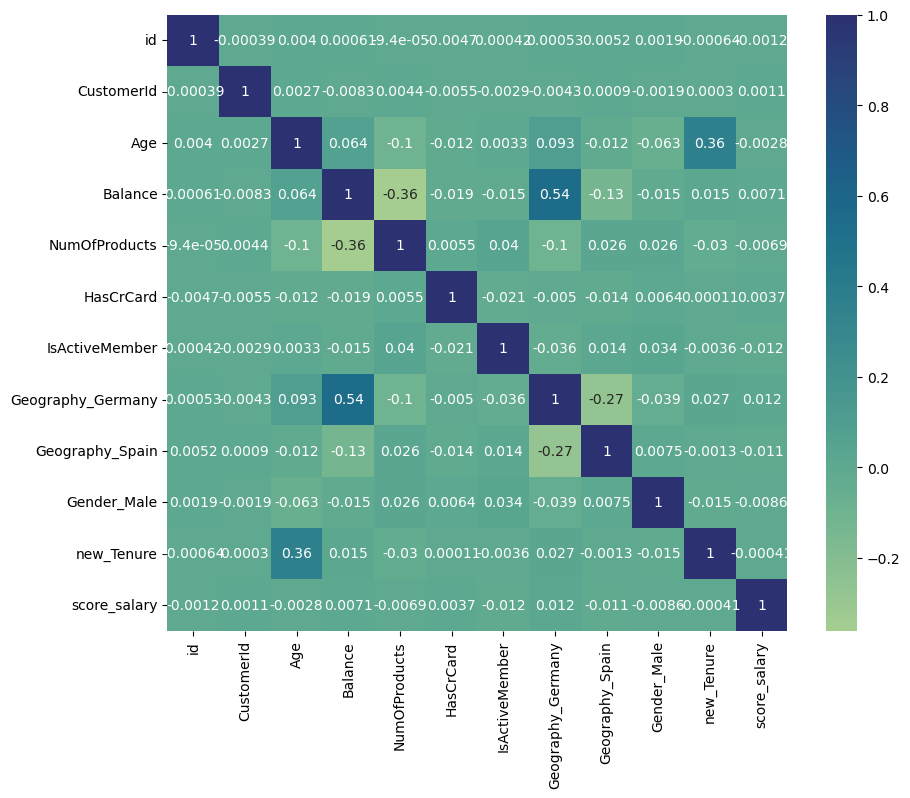

In [176]:
corr=new_X_train.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,annot=True,cmap='crest')

In [177]:
train_id=new_X_train.id
test_id=new_X_test.id
new_X_train=new_X_train.drop(['CustomerId','id'],axis=1)
new_X_test=new_X_test.drop(['CustomerId','id'],axis=1)

In [178]:
new_X_test

,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,Geography_Germany,Geography_Spain,Gender_Male,new_Tenure,score_salary
0,23.0,0.00,2,0.0,1.0,0,0,0,23.0,274.704352
1,46.0,0.00,1,1.0,0.0,0,0,0,46.0,106.221479
2,34.0,0.00,2,1.0,0.0,0,0,0,119.0,211.710503
3,36.0,0.00,1,1.0,0.0,0,0,1,144.0,167.300396
4,38.0,121263.62,1,1.0,0.0,1,0,1,190.0,185.413564
...,...,...,...,...,...,...,...,...,...,...
110018,29.0,116099.82,1,1.0,1.0,0,1,1,101.5,259.802842
110019,36.0,178032.53,1,1.0,1.0,0,0,0,72.0,73.359443
110020,31.0,0.00,2,1.0,0.0,0,0,1,31.0,22.875534
110021,32.0,0.00,1,1.0,1.0,0,0,0,48.0,224.000818


# Feature Scaling

In [179]:
X_train_cols=new_X_train.columns

In [180]:
#ss=StandardScaler()
#new_X_train=ss.fit_transform(new_X_train)
#new_X_train=pd.DataFrame(new_X_train,columns=X_train_cols)
#new_X_test=ss.fit_transform(new_X_test)
#new_X_test = pd.DataFrame(new_X_test, columns=X_train_cols)

In [181]:
new_X_train

,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,Geography_Germany,Geography_Spain,Gender_Male,new_Tenure,score_salary
0,33.0,0.00,2,1.0,0.0,0,0,1,49.5,271.631692
1,33.0,0.00,2,1.0,1.0,0,0,1,16.5,78.952951
2,40.0,0.00,2,1.0,0.0,0,0,1,200.0,272.664735
3,34.0,148882.54,1,1.0,1.0,0,0,1,34.0,145.543683
4,33.0,0.00,2,1.0,1.0,0,1,1,82.5,21.045852
...,...,...,...,...,...,...,...,...,...,...
165029,33.0,0.00,1,1.0,1.0,0,1,0,33.0,197.653298
165030,35.0,0.00,1,0.0,0.0,0,0,1,52.5,166.457639
165031,31.0,0.00,1,1.0,1.0,0,0,1,77.5,225.539044
165032,30.0,161533.00,1,0.0,1.0,0,1,0,105.0,128.471173


In [182]:
new_X_test

,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,Geography_Germany,Geography_Spain,Gender_Male,new_Tenure,score_salary
0,23.0,0.00,2,0.0,1.0,0,0,0,23.0,274.704352
1,46.0,0.00,1,1.0,0.0,0,0,0,46.0,106.221479
2,34.0,0.00,2,1.0,0.0,0,0,0,119.0,211.710503
3,36.0,0.00,1,1.0,0.0,0,0,1,144.0,167.300396
4,38.0,121263.62,1,1.0,0.0,1,0,1,190.0,185.413564
...,...,...,...,...,...,...,...,...,...,...
110018,29.0,116099.82,1,1.0,1.0,0,1,1,101.5,259.802842
110019,36.0,178032.53,1,1.0,1.0,0,0,0,72.0,73.359443
110020,31.0,0.00,2,1.0,0.0,0,0,1,31.0,22.875534
110021,32.0,0.00,1,1.0,1.0,0,0,0,48.0,224.000818


# Training Models 

In [198]:
#model = XGBClassifier(objective="binary:logistic", random_state=42, verbosity=3, learning_rate= 0.18, max_depth=5, n_estimators=175)
#model.fit(new_X_train, y_train)
#pred=model.predict(new_X_test)

[18:33:44] ======== Monitor (0): HostSketchContainer ========
[18:33:44] AllReduce: 0.001256s, 1 calls @ 1256us

[18:33:44] MakeCuts: 0.001342s, 1 calls @ 1342us

[18:33:44] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[18:33:44] ======== Monitor (0): Learner ========
[18:33:44] Configure: 0.000356s, 1 calls @ 356us

[18:33:44] EvalOneIter: 0.00204s, 175 calls @ 2040us

[18:33:44] GetGradient: 0.059481s, 175 calls @ 59481us

[18:33:44] PredictRaw: 0.00048s, 175 calls @ 480us

[18:33:44] UpdateOneIter: 0.467794s, 175 calls @ 467794us

[18:33:44] ======== Monitor (0): GBTree ========
[18:33:44] BoostNewTrees: 0.404573s, 175 calls @ 404573us

[18:33:44] CommitModel: 0.000206s, 175 calls @ 206us

[18:33:44] ======== Monitor (0): HistUpdater ========
[18:33:44] BuildHistogram: 0.080783s, 700 calls @ 80783us

[18:33:44] EvaluateSplits: 0.025463s, 875 calls @ 25463us

[18:3

In [201]:
lgbm=LGBMClassifier(max_depth=10, n_estimators=150, learning_rate=0.12)
model=lgbm.fit(new_X_train, y_train)
pred=model.predict(new_X_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 34921, number of negative: 130113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 850
[LightGBM] [Info] Number of data points in the train set: 165034, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211599 -> initscore=-1.315315
[LightGBM] [Info] Start training from score -1.315315
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [202]:
pred

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [203]:
prob=(np.round_(xgb_model2.predict_proba(new_X_test), decimals=1))
probdf=pd.DataFrame(prob)
probdf
      

,0,1
0,1.0,0.0
1,0.2,0.8
2,1.0,0.0
3,0.8,0.2
4,0.6,0.4
...,...,...
110018,1.0,0.0
110019,0.9,0.1
110020,1.0,0.0
110021,0.8,0.2


In [204]:
submission_df=pd.DataFrame()
submission_df['id']=test_id
submission_df['Exited']=probdf[1]
submission_df

,id,Exited
0,165034,0.0
1,165035,0.8
2,165036,0.0
3,165037,0.2
4,165038,0.4
...,...,...
110018,275052,0.0
110019,275053,0.1
110020,275054,0.0
110021,275055,0.2


In [205]:
submission_df = submission_df.drop_duplicates(subset='id', keep='first')  # Keep first occurrence
submission_df.to_csv('corrected_submission.csv', index=False)